这里讨论Auto-Encoding Variational Bayes一文对VAE（变分自动编码器）的实现。

VAE的第一部分描述一个受参数$\theta$控制的生成模型，隐变量先验分布$p_\theta(Z)$，
通常假定$p_\theta(Z) = N(Z ; \mathbf{0},\mathbf{I})$，即多元标准正态分布，且不受参数$\theta$影响。
然后设条件概率$p_\theta(X \mid Z)$，如果后者也是确定的，则已经给定了联合的概率模型$p_\theta(X,Z) = p_\theta(X \mid Z) p_\theta(Z)$。

如果$Z$其实也是可以观察到的，即我们把变量分成两个类型，类似于回归。则上述过程可以以极大似然法直接优化，我们要在$\theta$和函数形式
能表达的范围里使得联合似然$p_\theta(X,Z)$最大化。如果$p_\theta(X \mid Z)$看起来不好表示，我们可以用一个神经网络，一般函数
近似器替换。当然神经网络直接作为概率函数会平添对其优化时的取值产生限制，常用方法是让神经网络输入$Z$输出相对可以自由取值的分布参数，
如独立多元正态的期望向量和对数化标准差向量。比如我们可以想到，$Z$是一些标签，将$Z$映射到一组坐标和各坐标上的标准差上，可以描述
该分类下的分布情况一般。当然实际上我们经常做相反的事，即分类任务。而生成的结果如果只是在一个标签映射到的分布上采样，也未免太虚弱了一些，
这就是为什么生成式模型远远没有分类这种判定式模型有用的原因。（当然确切的说其实应该算某种鉴别式的生成模型，生成本身的判别标准
应该是没有任何额外信息下可以生成，这里对应着标签也应该被当做是一个分布里采样出来的而不是给定分布再采样。）

现在考虑如果$Z$并不是可观测的呢？这些隐变量有时候加入模型是有“理论依据”的（就像计量经济学里一样），有时只是为了增强模型的表达能力。
没有隐变量和没有参数的模型是两个比较容易处理的极端，前者使用常规的极大似然法，后者，即所谓完全贝叶斯情况（此得名
是因为这常常是通过把非随机参数加上钦定的先验分布后随机化为隐变量而来的）可以利用直接利用变分推断和采样（利用后验隐式的估计，
当然自带了不确定性信息）。然而隐变量和待估参数同时存在时就引发了一些困难，前面两种方法并不相容，怎么估计呢？目标是什么？

完全参数情况的目标是似然函数极大化，变分推断的完全贝叶斯则是变分参数控制下近似后验分布和精确后验分布的差距极小化（利用KL散度之类的）。
这两个目标并不能自然地合成，常见的算法为EM算法，即一个阶段固定参数，剩下的隐变量构成一个完全贝叶斯模型。另一个阶段固定计算出的
隐变量的精确或近似后验分布，优化参数，两阶段交替执行。不过EM算法通常指隐变量后验分布能快速地精确计算出的情况，它的主要开销应该在
参数优化那一步。采样或变分推断甚至作为单独的任务在大数据集下都难以工作，更不要说作为EM算法的一步了。

EM算法的优化目标本身是极大化可观测变量的边缘概率/似然，后验那个即使基于前者优化出的值计算也不一定是精确的（如果精确后验是指根据真实模型
的参数计算出的后验概率的话，更糟的是由于我们讨论的是分布，还不能直接用方差之类的衡量近似的程度，比如基于EM算法
同时估计的后验的抽样“差异”统计量之类的并没有自然的表示，也许KL散度可以试试），当然如果能算出来也是有用的。

VAE是怎么办的呢？首先它的生成模型，除了$p(z)$是确定的,以外的$p(x \mid Z)$全是由复杂的神经网络结构加上参数$\theta$确定的。这就是个
既有隐变量也有参数的例子。是否可以用EM算法？固定参数怎么计算它的后验分布$p(Z \mid X)$？由于这里$Z$是多维的连续变量，这并不好解决。
所以不能用一般意义上的EM算法。那么假如这步是近似计算的呢？I mean，把$\theta$暂且固定不变，然后去优化某个近似后验
$q_\phi(Z \mid X) \sim p_\theta(Z \mid X)$?这里$\phi$是$q(\cdot)$的参数，即变分参数。于是我们可以固定参数后KL散度最小化计算变分参数
确定（近似）后验分布，然后再固定近似后验分布最大化参数。

仔细一想，可以发现其实分两步并没有必要，这两件事可以放一起做，true EM算法之所以不这么做是因为在那那么做对应着分析地算出边缘似然后直接
最大化，而既然要用EM算法就肯定不是能一起做的（而近似毕竟只是近似，即使是神经网络的近似，一那么做就失去了完美的精确性）。

让我们怎么像true EM算法一样分别做两步再考虑合起来。

在原版的VAE中近似后验分布$q(Z \mid X)$被假定为正态分布，也就是说decoder的神经网络可以是一个由$X$到期望与对数标准差两个正态分布参数的映射，
there is:

$$
q(Z \mid X) = \frac{1}{\sqrt{2\pi}\sigma(x)} e^{-\frac{(z-\mu(x))}{2\sigma^2(x)}}
$$

其中$\mu(x),\sigma(x)$是由变分参数$\phi$控制下复杂的神经网络描述的，维持可微性。

以上公式是单个隐变量对应的近似后验，完全的对数近似后验基于它们对$X$条件独立从而可以分解的假设（没什么道理，完全服务于计算的假设）：

$$
\log q(Z \mid X) = \log q(Z_1 \mid X) \dots q(Z_H \mid X) = \sum_{i=1}^H \log q(Z_i \mid X) = 
\sum_{i=1}^H ((-\log(\sqrt{2\pi}\sigma_i(X))) + \frac{z_i - \mu_i(X)}{2\sigma_i^2(X)})
$$

以上公式是单样本的近似后验，样本独立同分布假设下的近似全样本联合后验有：

$$
\log q(Z \mid X) = \log \prod_j^N q(Z^{(j)} \mid X^{(j)}) = \log \prod_j^N \prod_i^H q(Z_i^{(j)} \mid X^{(j)}) =
\sum_{j=1}^N \sum_{i=1}^H \log N(Z_i^{(j)};\mu_i(X^{(j)}),\sigma_i(X^{(j)}))
$$

此近似后验的优化目标是控制$\phi$调整$\mu_i(X),\sigma_i(X)$与$\theta$控制下的“真实”后验（考虑到$p_\theta(Z \mid X)$的精确值
也是以估计的值定义而不是从真实模型里定义出来的，它的“真实性”似乎不是那么完全）差别尽可能小，如果不能精确计算KL散度的话。
容易利用蒙特卡洛近似计算ELBO，即

$$
\mathcal{L}(\theta,\phi,x^{(i)}) = E_{q_\phi(Z \mid x)}(-\log q_\phi(z \mid x) + \log p_\theta(x,z))
\approx \frac{1}{L} \sum_{l=1}^L (\log p_\theta(x^{(i)},z^{(i,l)})-\log q_\phi (z^{(i,l)} \mid x^{(i)})))
$$

这里$L$是蒙特卡洛采样$z$的次数，$l$表示第$l$个采样（不是样本），$i$表示其为来自原数据第i个样本的部分。完全ELBO会把所有这样的项加起来，
batch版会滚动采$M$个或从原数据中随机抽$M$个。每个这样的项都分别抽$Z$（以不同的$X$决定的分布/encoder决定的分布参数），如此
$M$可以替代$L$的效果一定程度上，所以和ADVI和受限玻尔兹曼机一样，$L=1$是常用设定。

那么是否直接可以对后者求$\phi$的梯度呢，那里有个$q_\phi$好像可以算出梯度。然而并不行。把期望以积分形式展开，可以注意到：

$$
\mathcal{L}(\theta,\phi,x^{(i)}) = \int_Z q_\phi(Z \mid X) (-\log q_\phi(z \mid x) + \log p_\theta(x,z)) dZ
$$

如果下式成立：

$$
\begin{align}
\nabla \mathcal{L}(\theta,\phi,x^{(i)}) &= \nabla \int_Z q_\phi(Z \mid X) (-\log q_\phi(z \mid x) + \log p_\theta(x,z)) dZ \\
                           &=\int_Z \nabla( q_\phi(Z \mid X) (-\log q_\phi(z \mid x) + \log p_\theta(x,z))) dZ \\
                           &= \int_Z q_\phi(Z \mid X) \nabla (-\log q_\phi(z \mid x) + \log p_\theta(x,z))) dZ
\end{align}
$$

我们倒是可以可以直接对后者求梯度计算近似梯度，然而该推导明显是错的。如果加权项与$\phi$无关（用另一个方向的KL散度也许可以做到这点）
这样算可能是合法的。然而并不行实际上。

怎么办呢？和微积分遇到这类情况类似，我们可以将积分变量换掉来达成想要的效果，即重参数化技巧，
我们前面已经设了$q$可以表示为$\mu_\phi(X),\sigma_\phi(X)$与正态分布密度函数之积。于是可以设

$$
Z = \epsilon \sigma_\phi(X) + \mu_\phi(X) \quad \epsilon \sim N(0,1)
$$

于是以下论证是合法的：

$$
\begin{align}
\nabla \mathcal{L}(\theta,\phi,x^{(i)}) 
&= \nabla \int_\epsilon N(\epsilon;0,1) (-\log q_\phi(\epsilon \sigma_\phi(X) + \mu_\phi(X) \mid x) + \log p_\theta(x,\epsilon \sigma_\phi(X) + \mu_\phi(X))) d\epsilon \\
&=  \int_\epsilon N(\epsilon;0,1) \nabla( (-\log q_\phi(\epsilon \sigma_\phi(X) + \mu_\phi(X) \mid x) + \log p_\theta(x,\epsilon \sigma_\phi(X) + \mu_\phi(X)))) d\epsilon
\end{align}
$$

于是我们可以基于此重参数化技巧计算近似梯度：

$$
\begin{align}
\mathcal{L}(\theta,\phi,x^{(i)}) 
&= E_{q_\phi(Z_\phi(X) \mid x)}(-\log q_\phi(Z_\phi(X) \mid x) + \log p_\theta(x,Z_\phi(X))) \\
&\approx \frac{1}{L} \sum_{l=1}^L (\log p_\theta(x^{(i)},Z_\phi(X)^{(i,l)})-\log q_\phi (Z_\phi(X)^{(i,l)} \mid x^{(i)}))) \\
Z_\phi(X) &= \epsilon \sigma_\phi(X) + \mu_\phi(X) \\
\epsilon &\sim N(0,1)
\end{align}
$$

现在我们可以固定$\theta$去优化$\phi$到满意了，然后怎么固定$\phi$(对应的（近似）后验分布)去优化$\theta$？

EM算法在这一步把目标函数从边缘概率

$$
p_\theta(X) = \int_Z p_\theta(X,Z)
$$

换成了用之前计算出的$Z$的后验分布的对数联合概率的条件期望：

$$
E_{p_{\theta_0}(z \mid X)}(\log p_\theta(X,Z)) = \int_z p_{\theta_0}(Z \mid X) \log p_\theta(X,Z)
$$

$\theta_0$表示之前步骤中所使用的固定的$\theta$，它们不会被求梯度，已被融合到后验信息里（从这可以看出它同时做了一个类似重参数化技巧干的事，
把积分右边那个项与所求梯度关系解除。）

然后最大化之，而精确计算的前者可以看成在用$I(z) = 1$来加权，所以EM算法虽然直观上看是有效的，但细究起来它为什么能收敛到正确解并不显然。

However，我们假定EM算法的正确性可以沿用到这个问题上来，所以我们把精确的$p_\theta(z \mid x)$直接换成近似后验$q_\phi(z \mid x)$,有：

$$
E_{q_\phi(z \mid X)} (\log p_\theta(X,Z)) 
= \int_z q_\phi(Z \mid X) \log p_\theta(X,Z) 
\approx \frac{1}{L} \sum_{l=1}^L \log p_\theta(X,Z_\phi(X))
$$

由于计算后验分布那一步两个项中另一个项与$\theta$无关，我们就发现我们可以同时对ELBO的$\phi$的梯度相同的方式来优化$\theta$。

$$
\nabla_\theta \mathcal{L}(\theta,\phi,X^{(i)}) \approx \nabla_\theta \frac{1}{L} \sum_{l=1}^L \log p_\theta(X,Z_\phi(X))
$$

从而可以同时求梯度优化生成/识别参数$\theta$与变分参数$\phi$:

$$
\nabla_{\theta,\phi} \mathcal{L}(\theta,\phi,X^{(i)})
$$

不过原文里用的VAE通过给将近似后验分布$q_\phi(Z \mid X)$和生成隐变量先验分布$p_\theta(Z)$都限制为独立多元正态分布
（后者进一步限制为标准正态分布），使得KL散度可以直接求出来。不过我们依然直接使用ELBO优化以take advantage of parallel optimization on two 
target.不过KL散度可以减少一部分采样随机估计引来的随机性。

首先我们recall KL divergence与ELBO的关系：

$$
\mathcal{L} (\theta,\phi,x^{(i)}) = -D_{KL} (q_\phi(Z \mid X^{(i)}) || p(Z)) + E_{q_\phi{Z \mid X}}(\log p_\theta(X^{(i)} \mid Z))
$$

右边的右边的式子依然用采样近似求梯度：

$$
\begin{align}
E_{q_\phi{Z \mid X}}(\log p_\theta(X^{(i)} \mid Z)) 
&\approx \frac{1}{L} \sum_{l=1}^L \log p_\theta(X^{(i)} \mid Z_\phi(X,\epsilon)) \\
Z_\phi(X,\epsilon) &= \epsilon \sigma(X) + \mu(X) \\
\epsilon &\sim N(\mathbf{0},\mathbf{I})
\end{align}
$$

分解 KL divergence(下面将$q_\phi(Z \mid X)$记为$q_\phi(z)$，因为并没有用到它作为条件分布的性质):

$$
- D_{KL}(q_\phi(z) || p(Z)) = - E_{q_\phi(z)} \log \frac{q_\phi(z)}{p(Z)} = 
E_{q_\phi(z)} - \log(q_\phi(z)) + \log p(Z) = - \int_Z q_\phi(z) \log(q_\phi(z)) + \int_Z q_\phi(Z) \log P(Z)
$$

VAE假设：

$$
\begin{align}
p(Z) = N(Z;\mathbf{0},\mathbf{I})
&= \mathrm{det}{2\pi \Sigma}^{-1/2} \exp(-1/2 (Z-\mu)'\Sigma^{-1}(Z-\mu)) \quad (\mu = \mathbf{0} \quad \Sigma = \mathbf{I}) \\
&= (2\pi)^{-J/2} \exp(-1/2 Z'Z) \\
\log P(Z) &= (-J/2) \log(2\pi) - \frac{1}{2}Z'Z = (-J/2) \log(2\pi) - \frac{1}{2}\sum_{j=1}^J Z_j^2 \\
q_\phi(Z \mid X) &= N(Z ; \mathbf{\mu}_\phi(X), \mathbf{\sigma}_\phi(X)) \\
&= ((2\pi)^J \prod_j^J \sigma^2_j)^{-1/2} \exp(1/2 (Z-\mu)' \mathrm{diag}(1/\sigma^2_1,\dots,1/\sigma^2_J) (Z-\mu)) \\
\log q(Z) &= -1/2 (J\log(2\pi)+ \sum_{j=1}^J \log \sigma^2_j) + \frac{1}{2} (Z-\mu)' \mathrm{diag}(1/\sigma^2_1,\dots,1/\sigma^2_J) (Z-\mu) \\
&= -1/2 (J\log(2\pi))+ \sum_{j=1}^J \log \sigma^2_j) + \frac{1}{2} \sum_{j=1}^J \frac{(Z_j - \mu_j)^2}{\sigma_j^2}
\end{align}
$$

其中$J$为隐变量的个数/维数。$\mu_j(X)$等指以神经网络表示的从可观测变量$X$到隐变量$Z_j$近似正态分布的期望参数的映射，$\sigma_j(X)$类似。

分别计算KL散度两个项：

$$
\begin{align}
\int_Z q_\phi(z)\log(q_\phi(z)) = \int_Z 
((2\pi)^J \prod_j^J \sigma^2_j)^{-1/2} \exp\left(-\frac{1}{2} \sum_{j=1}^J \frac{(Z_j - \mu_j)^2}{\sigma_j^2} \right)
((-1/2 (J\log(2\pi)+ \sum_{j=1}^J \log \sigma^2_j)- \frac{1}{2} \sum_{j=1}^J \frac{(Z_j - \mu_j)^2}{\sigma_j^2})
\end{align}
$$

这么算就脑残了，可以注意到$\log q(Z)$右边那个项在此对称积分可以凑成一个$N(0,1)$的二阶矩，即1（$0^2+1^2$），
多重积分里其他项直接按概率积分算成1。

$$
\begin{align}
\int_Z q_\phi(z)\log(q_\phi(z)) 
&= \int_Z N(Z;\mu,\sigma^2) \log N(Z;\mu,\sigma^2) \\
&= \int_Z N(Z;\mu,\sigma^2) (-1/2 (J\log(2\pi)+ \sum_{j=1}^J \log \sigma^2_j + \frac{(Z_j - \mu_j)^2}{\sigma_j^2}) \\
&= -1/2 (J\log(2\pi)+ \sum_{j=1}^J (\log \sigma^2_j) + 1)
\end{align}
$$

运用类似的概率积分技巧有：

$$
\begin{align}
\int_Z q_\phi(z) \log(p_\theta(Z)) 
&= \int_Z q(z) \log (p(Z)) \\
&= \int_Z N(Z;\mu,\sigma^2) (-J/2) \log(2\pi) - \frac{1}{2}\sum_{j=1}^J Z_j^2 \\
&= (-J/2) \log(2\pi) -\frac{1}{2} \sum_{j=1}^J \int_Z N(Z;\mu,\sigma^2) Z_j^2 \\
&=(-J/2) \log(2\pi) -\frac{1}{2} \sum_{j=1}^J (\mu_j^2 + \sigma_j^2)
\end{align}
$$

上述推导中多重积分$\int_Z$之所以可以那样化简是因为多元正态分布密度函数$N(Z;\mu,\sigma^2)$的各维是独立的，所以可以分成$J$个积分的乘积，
$Z_j^2$移进其中一个凑成一个二阶矩积分。

故而negative KL divergence为:

$$
\begin{align}
- D_{KL}(q_\phi(z) || p(Z))
&= - \int_Z q_\phi(z) \log(q_\phi(z)) + \int_Z q_\phi(Z) \log P(Z) \\
&= 1/2 (J\log(2\pi)+ \sum_{j=1}^J (1+\log \sigma^2_j)) -J/2 \log(2\pi) -\frac{1}{2} \sum_{j=1}^J (\mu_j^2 + \sigma_j^2) \\
&= \frac{1}{2} \sum_{j=1}^J (1+\log \sigma^2_j) - \frac{1}{2} \sum_{j=1}^J (\mu_j^2 + \sigma_j^2) \\
&= \frac{1}{2} \sum_{j=1}^J \left( 1 + \log \sigma^2_j -\mu_j^2 -\sigma_j^2 \right)
\end{align}
$$

理论解决了，我们先按那个一般的，不解析计算KL散度的方法用pytorch实现一下

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
%matplotlib inline

In [3]:
import torch.nn as nn
import torch.nn.functional as F


In [4]:
import torch.utils.data
from torchvision import datasets, transforms


In [5]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)


In [28]:

class VAE(nn.Module):
    def __init__(self,n_v,h_p=100,h_q=100,J=100,L=1,epsilon=1e-3):
        super().__init__()
        
        self.n_v = n_v
        self.h_p = h_p
        self.h_q = h_q
        self.J = J
        self.L = L
        
        self.W_p = nn.Parameter(torch.randn(J,h_p) * epsilon)
        self.b_p = nn.Parameter(torch.zeros(h_p))
        self.W_p_mu = nn.Parameter(torch.randn(h_p,n_v)*epsilon)
        self.b_p_mu = nn.Parameter(torch.zeros(n_v))
        self.W_p_omega = nn.Parameter(torch.randn(h_p,n_v)*epsilon)
        self.b_p_omega = nn.Parameter(torch.zeros(n_v))

        self.W_q = nn.Parameter(torch.randn(n_v,h_q)*epsilon)
        self.b_q = nn.Parameter(torch.zeros(h_q))
        self.W_q_mu = nn.Parameter(torch.randn(h_q,J)*epsilon)
        self.b_q_mu = nn.Parameter(torch.zeros(J))
        self.W_q_omega = nn.Parameter(torch.randn(h_q,J)*epsilon)
        self.b_q_omega = nn.Parameter(torch.zeros(J))

    def decode(self, code):
        '''VAE的encoder网络将像素向量映射成隐变量多元正态分布的两个参数，
        decoder网络将隐变量元素映射成像素向量多元正态分布的两个参数，
        从而并没有自然的确定性decode，encode方法像（非概率化）自动编码器和GAN那样，
        当然愿意抛弃部分信息的话可以当期望参数那部分当确定性输出，这里先不实现'''
        raise NotImplemented
    def encode(self, image):
        raise NotImplemented
    def x_to_z(self,x):
        o = F.relu(F.linear(x, self.W_q.t(), self.b_q)) # pytorch干吗把A转置一下有病吧。。是把数据总看成列向量的抽象？
        loc = F.linear(o, self.W_q_mu.t(), self.b_q_mu)
        scale = torch.exp(F.linear(o, self.W_q_omega.t(), self.b_q_omega))
        return loc,scale
    def z_to_x(self,z):
        o = F.relu(F.linear(z, self.W_p.t(), self.b_p))
        loc = F.linear(o, self.W_p_mu.t(), self.b_p_mu)
        scale = torch.exp(F.linear(o, self.W_p_omega.t(), self.b_p_omega))
        return loc,scale
    def log_p_z(self,z):
        return torch.distributions.Normal(0,1).log_prob(z)
    def log_p_x_z(self,x,z):
        loc,scale = self.z_to_x(z)
        log_p_x_given_z = torch.distributions.Normal(loc = loc, scale = scale).log_prob(x).sum(-1)
        log_p_z  =self.log_p_z(z).sum(-1)
        return log_p_x_given_z + log_p_z
    def log_q_z_given_x(self,x,z):
        loc,scale = self.x_to_z(x)
        return torch.distributions.Normal(loc = loc, scale=scale).log_prob(z).sum(-1)
    def ELBO_SGVB(self,x):
        loc,scale = self.x_to_z(x)
        M = x.shape[0] # current batch size
        epsilon = torch.randn(self.L, M, self.J) # place L axis on first axis to leverge batch-wise function
        z = epsilon*scale + loc
        L_batch = torch.mean(self.log_p_x_z(x,z) - self.log_q_z_given_x(x,z), 0) # mean L axis
        return L_batch.mean(0) # mean batch axis
    def ELBO_SGVB_KL(self,x):
        # use anaticlly KL divergence to avoid useless sample noise
        raise NotImplemented
    def ELBO_EXACT(self,x):
        raise NotImplemented
    def ELBO(self,x, method='SGVB'):
        method = getattr(self,f'ELBO_{method}')
        return method(x)
    


In [29]:
model = VAE(28*28,h_p=400,h_q=400,J=20,L=2,epsilon=1e-4)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [30]:
elbo__ = []

In [31]:
for epoch in range(15):
    elbo_ = []
    for data,target in train_loader:
        data = data.view(-1,784)
        elbo = model.ELBO(data)
        elbo_.append(elbo.item())
        
        opt.zero_grad()
        loss = -elbo
        loss.backward()
        opt.step()
    print(np.mean(elbo_))
    elbo__.append(elbo_)

121.51332373627976
449.4102022297093
490.52437194222324
740.1441074424207
734.2776418413434
825.4921212389524
756.261647271195
946.8134692503191
1033.8569948830839
1022.9135915068929
1115.2611084655405
971.2787704630447
1042.8894135408057
1069.409585664013
1076.562538244577


In [32]:
elbo__[-1][-20:]

[920.8052368164062,
 735.0584716796875,
 739.3317260742188,
 982.962890625,
 981.0399780273438,
 971.79248046875,
 924.6630859375,
 946.6151123046875,
 877.1334228515625,
 652.2564086914062,
 748.2710571289062,
 934.6314086914062,
 1001.5836791992188,
 977.40771484375,
 949.7188110351562,
 887.193603515625,
 977.990966796875,
 995.6553344726562,
 740.9070434570312,
 909.2598266601562]

In [33]:
from torchvision.utils import make_grid

In [34]:
list_train_loader = list(train_loader)

In [35]:
source = list_train_loader[0][0]
source.shape

torch.Size([64, 1, 28, 28])

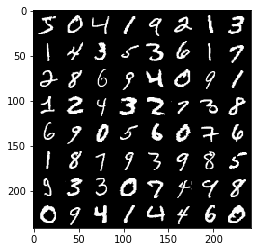

In [36]:
plt.imshow(make_grid(source).detach().numpy().transpose((1,2,0)))
plt.show()

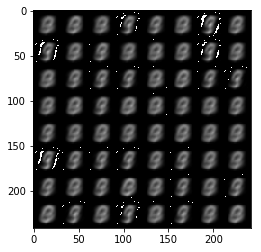

In [37]:
x = source.view(-1,28*28)
z_loc,z_scale = model.x_to_z(x)
z = z_loc
x_mu,x_scale = model.z_to_x(z)
x_recode = x_mu

source_recode = x_recode.view(source.shape)
plt.imshow(make_grid(source_recode).detach().numpy().transpose(1,2,0))
plt.show()

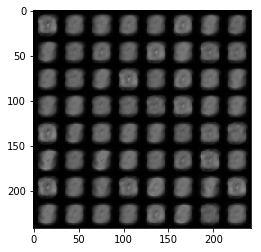

In [40]:
z_new = torch.randn_like(z)
source_sample = model.z_to_x(z_new)[0].new(source.shape)
plt.imshow(make_grid(source_sample).detach().numpy().transpose(1,2,0))
plt.show()

EMMM，sigmoid换relu前虽然重编码还是垃圾但采样还有个9的样子吧，这tm是什么。。溜了，换一套API，但还是不用解析KL梯度试一波。

下面把decoder条件分布$p_\theta(x \mid z)$改成伯努利分布看看。这样左边那个项的一部分变为二值交叉熵形式

$$
\mathcal{L}(\theta)= -\frac{1}{n}\sum_{i=1}^n \left[y_i \log(p_i) + (1-y_i) \log(1-p_i)\right] 
= -\frac{1}{n}\sum_{i=1}^n\sum_{j=1}^m y_{ij} \log(p_{ij})
$$

In [41]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc_x_to_z = nn.Linear(28*28,400)
        self.fc_x_to_z_mu = nn.Linear(400,20)
        self.fc_x_to_z_logvar = nn.Linear(400,20)
        
        self.fc_z_to_x = nn.Linear(20,400)
        self.fc_z_to_x_p = nn.Linear(400,28*28)
        
    def x_to_z(self,x):
        o = F.relu(self.fc_x_to_z(x))
        mu = self.fc_x_to_z_mu(o)
        logvar = self.fc_x_to_z_logvar(o)
        return mu,logvar
    
    def z_to_x(self,z):
        o = F.relu(self.fc_z_to_x(z))
        p = F.sigmoid(self.fc_z_to_x_p(o))
        return p
    
    def logp_z(self,z):
        return torch.distributions.Normal(0,1).log_prob(z).sum(-1)
    def logp_x_given_z(self,x,z):
        p = self.z_to_x(z)
        return (x * torch.log(p) + (1-x)*torch.log(1-p)).sum(-1)
    def logp_x_z(self,x,z):
        return self.logp_x_given_z(x,z) + self.logp_z(z)
    def logq_z_given_x(self,x,z):
        mu,logvar = self.x_to_z(x)
        return torch.distributions.Normal(mu,torch.exp(logvar)).log_prob(z).sum(-1)
    def elbo(self,x):
        mu,logvar = self.x_to_z(x)
        epsilon = torch.randn_like(mu)
        z = epsilon * torch.exp(logvar) + mu
        elbo = (self.logp_x_z(x,z) - self.logq_z_given_x(x,z)).sum() # L = 1
        return elbo

In [42]:
model = VAE()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [43]:
elbo__ = []

In [44]:
for epoch in range(5):
    elbo_ = []
    for data,target in train_loader:
        data = data.view(-1,784)
        elbo = model.elbo(data)
        elbo_.append(elbo.item())
        
        opt.zero_grad()
        loss = -elbo
        loss.backward()
        opt.step()
    print(np.mean(elbo_))
    elbo__.append(elbo_)

-9894.135984766457
-7579.763280937666
-7208.445482721715
-7058.784107590535
-6975.012150811234


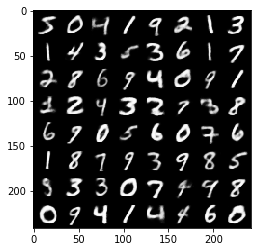

In [45]:
x = source.view(-1,28*28)
z_loc,z_scale = model.x_to_z(x)
z = z_loc
x_p = model.z_to_x(z)
x_recode = x_p

source_recode = x_recode.view(source.shape)
plt.imshow(make_grid(source_recode).detach().numpy().transpose(1,2,0))
plt.show()

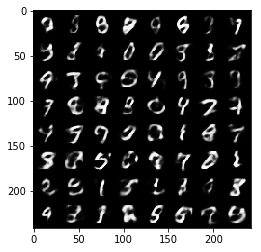

In [46]:
z_new = torch.randn_like(z)
source_sample = model.z_to_x(z_new).view(source.shape)
plt.imshow(make_grid(source_sample).detach().numpy().transpose(1,2,0))
plt.show()

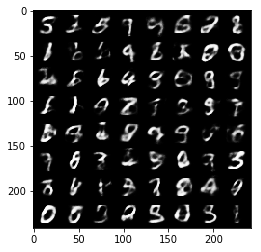

In [47]:
z_new = torch.randn_like(z)
source_sample = model.z_to_x(z_new).view(source.shape)
plt.imshow(make_grid(source_sample).detach().numpy().transpose(1,2,0))
plt.show()

效果还不错，感觉之前其实是绘图函数的原因。。假设分布错误的影响这么大的吗。